In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import glob
import time
import cv2

from sklearn.utils import shuffle


%matplotlib inline

In [ ]:
_cars = glob.glob('./data/vehicles/*/*.png')
_notcars = glob.glob('./data/non-vehicles/*/*.png')

print("Original - Car image count: {}, non-car image count: {}".format(len(_cars), len(_notcars)))

In [ ]:
def show_sample(car_image, non_car_image):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
    f.tight_layout()
    
    ax1.imshow(mpimg.imread(car_image))
    ax1.set_title("car", fontsize=15)

    ax2.imshow(mpimg.imread(non_car_image))
    ax2.set_title('Non-car', fontsize=15)
    
    plt.show()
    
show_sample(_cars[250], _notcars[250])

In [ ]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        if file.endswith(".png"):
            image = (image*255).astype(np.uint8)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows   

In [ ]:
cars = shuffle(_cars)
notcars = shuffle(_notcars)

# Take only part of the data
percent = 0.7

# set the sample size
sample_size = min(len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

print("Sample - car image count: {}, non-car image count: {}".format(len(cars), len(notcars)))

In [ ]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [ ]:
t=time.time() # Start time

image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                xy_window=(96, 96), xy_overlap=(0.7, 0.7))
hot_windows = (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat))                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
print(round(time.time()-t, 2), 'Seconds to process test image')

In [ ]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    draw_image = np.copy(image)
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    axs[i * 2].imshow(image)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(window_img)
    axs[i * 2 + 1].axis('off')

In [141]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    img_tosearch = img[ystart:ystop,500:,:]
        
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = img_tosearch 
       
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox_left_top = (500 + xbox_left, ytop_draw+ystart)
                bbox_right_bottom = (500 + xbox_left+win_draw,ytop_draw+win_draw+ystart)
                
                bbox_list.append((bbox_left_top, bbox_right_bottom))
    return bbox_list

In [142]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    heatmap = np.clip(heatmap, 0, 255)

    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

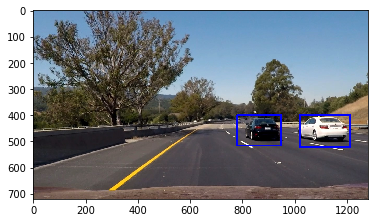

In [143]:
def detect_cars(image):
    new_img = np.copy(image)
    bbox_list = []
    
    multi_window_setting = [
        (400, 1.0),
        (408, 1.0),
        (400, 1.5),
        (420, 1.5),
        (400, 2.0),
        (432, 2.0)
    ]
    
    for ystart, scale in multi_window_setting:
        ystop = ystart + int(64 * scale)
        
        bbox_list.extend(find_cars(image, ystart, ystop, scale, color_space, hog_channel,svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    
    from skimage.filters import gaussian
    heat = gaussian(heat, 3)
    
    heat = apply_threshold(heat, len(multi_window_setting)//2+1)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(new_img, labels)
    
    return new_img
    
img = detect_cars(image)
plt.imshow(img)

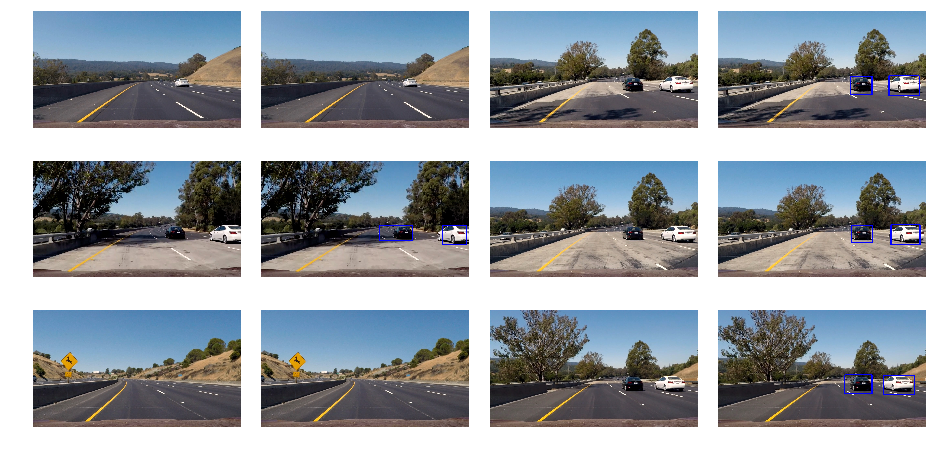

In [144]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)

    axs[i * 2].imshow(image)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(detect_cars(image))
    axs[i * 2 + 1].axis('off')

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [146]:
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:16,  2.25it/s]

  5%|▌         | 2/39 [00:00<00:16,  2.20it/s]

  8%|▊         | 3/39 [00:01<00:16,  2.16it/s]

 10%|█         | 4/39 [00:01<00:16,  2.13it/s]

 13%|█▎        | 5/39 [00:02<00:16,  2.12it/s]

 15%|█▌        | 6/39 [00:02<00:15,  2.13it/s]

 18%|█▊        | 7/39 [00:03<00:14,  2.14it/s]

 21%|██        | 8/39 [00:03<00:14,  2.11it/s]

 23%|██▎       | 9/39 [00:04<00:14,  2.10it/s]

 26%|██▌       | 10/39 [00:04<00:14,  2.04it/s]

 28%|██▊       | 11/39 [00:05<00:13,  2.04it/s]

 31%|███       | 12/39 [00:05<00:13,  2.05it/s]

 33%|███▎      | 13/39 [00:06<00:12,  2.01it/s]

 36%|███▌      | 14/39 [00:06<00:12,  2.02it/s]

 38%|███▊      | 15/39 [00:07<00:11,  2.01it/s]

 41%|████      | 16/39 [00:08<00:11,  1.99it/s]

 44%|████▎     | 17/39 [00:08<00:11,  1.99it/s]

 46%|████▌     | 18/39 [00:09<00:10,  1.99it/s]

 49%|████▊     | 19/39 [00:09<00:10,  2.00it/s]

 51%|█████▏    | 20/39 [00:09<00:09,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 1min 8s, sys: 511 ms, total: 1min 8s
Wall time: 19.3 s


In [147]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(0,10)
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<09:07,  2.30it/s]

  0%|          | 2/1261 [00:00<09:31,  2.20it/s]

  0%|          | 3/1261 [00:01<09:34,  2.19it/s]

  0%|          | 4/1261 [00:01<09:41,  2.16it/s]

  0%|          | 5/1261 [00:02<09:49,  2.13it/s]

  0%|          | 6/1261 [00:02<10:01,  2.09it/s]

  1%|          | 7/1261 [00:03<10:03,  2.08it/s]

  1%|          | 8/1261 [00:03<10:03,  2.08it/s]

  1%|          | 9/1261 [00:04<10:05,  2.07it/s]

  1%|          | 10/1261 [00:04<10:04,  2.07it/s]

  1%|          | 11/1261 [00:05<10:04,  2.07it/s]

  1%|          | 12/1261 [00:05<10:00,  2.08it/s]

  1%|          | 13/1261 [00:06<10:00,  2.08it/s]

  1%|          | 14/1261 [00:06<09:56,  2.09it/s]

  1%|          | 15/1261 [00:07<09:54,  2.10it/s]

  1%|▏         | 16/1261 [00:07<09:54,  2.09it/s]

  1%|▏         | 17/1261 [00:08<09:54,  2.09it/s]

  1%|▏         | 18/1261 [00:08<09:51,  2.10it/s]

  2%|▏         | 19/1261 [00:09<09:49,  2.11it/

 11%|█▏        | 143/1261 [01:11<09:19,  2.00it/s]

 11%|█▏        | 144/1261 [01:12<09:19,  2.00it/s]

 11%|█▏        | 145/1261 [01:12<09:19,  2.00it/s]

 12%|█▏        | 146/1261 [01:13<09:18,  2.00it/s]

 12%|█▏        | 147/1261 [01:13<09:17,  2.00it/s]

 12%|█▏        | 148/1261 [01:14<09:17,  2.00it/s]

 12%|█▏        | 149/1261 [01:14<09:17,  2.00it/s]

 12%|█▏        | 150/1261 [01:15<09:16,  2.00it/s]

 12%|█▏        | 151/1261 [01:15<09:16,  1.99it/s]

 12%|█▏        | 152/1261 [01:16<09:16,  1.99it/s]

 12%|█▏        | 153/1261 [01:16<09:15,  1.99it/s]

 12%|█▏        | 154/1261 [01:17<09:15,  1.99it/s]

 12%|█▏        | 155/1261 [01:17<09:14,  1.99it/s]

 12%|█▏        | 156/1261 [01:18<09:14,  1.99it/s]

 12%|█▏        | 157/1261 [01:18<09:13,  1.99it/s]

 13%|█▎        | 158/1261 [01:19<09:13,  1.99it/s]

 13%|█▎        | 159/1261 [01:19<09:13,  1.99it/s]

 13%|█▎        | 160/1261 [01:20<09:13,  1.99it/s]

 13%|█▎        | 161/1261 [01:20<09:12,  1.99it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [02:24<08:17,  1.96it/s]

 23%|██▎       | 285/1261 [02:25<08:17,  1.96it/s]

 23%|██▎       | 286/1261 [02:25<08:16,  1.96it/s]

 23%|██▎       | 287/1261 [02:26<08:16,  1.96it/s]

 23%|██▎       | 288/1261 [02:26<08:16,  1.96it/s]

 23%|██▎       | 289/1261 [02:27<08:15,  1.96it/s]

 23%|██▎       | 290/1261 [02:27<08:15,  1.96it/s]

 23%|██▎       | 291/1261 [02:28<08:14,  1.96it/s]

 23%|██▎       | 292/1261 [02:28<08:14,  1.96it/s]

 23%|██▎       | 293/1261 [02:29<08:13,  1.96it/s]

 23%|██▎       | 294/1261 [02:29<08:13,  1.96it/s]

 23%|██▎       | 295/1261 [02:30<08:12,  1.96it/s]

 23%|██▎       | 296/1261 [02:30<08:12,  1.96it/s]

 24%|██▎       | 297/1261 [02:31<08:11,  1.96it/s]

 24%|██▎       | 298/1261 [02:31<08:11,  1.96it/s]

 24%|██▎       | 299/1261 [02:32<08:10,  1.96it/s]

 24%|██▍       | 300/1261 [02:32<08:10,  1.96it/s]

 24%|██▍       | 301/1261 [02:33<08:09,  1.96it/s]

 24%|██▍       | 302/1261 [02:34<08:09,  1.96it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [03:37<07:08,  1.95it/s]

 34%|███▍      | 426/1261 [03:38<07:07,  1.95it/s]

 34%|███▍      | 427/1261 [03:38<07:07,  1.95it/s]

 34%|███▍      | 428/1261 [03:39<07:06,  1.95it/s]

 34%|███▍      | 429/1261 [03:39<07:06,  1.95it/s]

 34%|███▍      | 430/1261 [03:40<07:05,  1.95it/s]

 34%|███▍      | 431/1261 [03:40<07:05,  1.95it/s]

 34%|███▍      | 432/1261 [03:41<07:04,  1.95it/s]

 34%|███▍      | 433/1261 [03:41<07:04,  1.95it/s]

 34%|███▍      | 434/1261 [03:42<07:03,  1.95it/s]

 34%|███▍      | 435/1261 [03:42<07:02,  1.95it/s]

 35%|███▍      | 436/1261 [03:43<07:02,  1.95it/s]

 35%|███▍      | 437/1261 [03:43<07:01,  1.95it/s]

 35%|███▍      | 438/1261 [03:44<07:01,  1.95it/s]

 35%|███▍      | 439/1261 [03:44<07:00,  1.95it/s]

 35%|███▍      | 440/1261 [03:45<07:00,  1.95it/s]

 35%|███▍      | 441/1261 [03:45<06:59,  1.95it/s]

 35%|███▌      | 442/1261 [03:46<06:59,  1.95it/s]

 35%|███▌      | 443/1261 [03:46<06:58,  1.95it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [04:49<05:55,  1.95it/s]

 45%|████▍     | 567/1261 [04:50<05:55,  1.95it/s]

 45%|████▌     | 568/1261 [04:50<05:54,  1.95it/s]

 45%|████▌     | 569/1261 [04:51<05:54,  1.95it/s]

 45%|████▌     | 570/1261 [04:51<05:53,  1.95it/s]

 45%|████▌     | 571/1261 [04:52<05:53,  1.95it/s]

 45%|████▌     | 572/1261 [04:52<05:52,  1.95it/s]

 45%|████▌     | 573/1261 [04:53<05:52,  1.95it/s]

 46%|████▌     | 574/1261 [04:53<05:51,  1.95it/s]

 46%|████▌     | 575/1261 [04:54<05:51,  1.95it/s]

 46%|████▌     | 576/1261 [04:54<05:50,  1.95it/s]

 46%|████▌     | 577/1261 [04:55<05:50,  1.95it/s]

 46%|████▌     | 578/1261 [04:55<05:49,  1.95it/s]

 46%|████▌     | 579/1261 [04:56<05:49,  1.95it/s]

 46%|████▌     | 580/1261 [04:57<05:48,  1.95it/s]

 46%|████▌     | 581/1261 [04:57<05:48,  1.95it/s]

 46%|████▌     | 582/1261 [04:58<05:47,  1.95it/s]

 46%|████▌     | 583/1261 [04:58<05:47,  1.95it/s]

 46%|████▋     | 584/1261 [04:59<05:46,  1.95it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [06:01<04:43,  1.95it/s]

 56%|█████▌    | 708/1261 [06:02<04:43,  1.95it/s]

 56%|█████▌    | 709/1261 [06:02<04:42,  1.95it/s]

 56%|█████▋    | 710/1261 [06:03<04:42,  1.95it/s]

 56%|█████▋    | 711/1261 [06:03<04:41,  1.95it/s]

 56%|█████▋    | 712/1261 [06:04<04:41,  1.95it/s]

 57%|█████▋    | 713/1261 [06:04<04:40,  1.95it/s]

 57%|█████▋    | 714/1261 [06:05<04:40,  1.95it/s]

 57%|█████▋    | 715/1261 [06:06<04:39,  1.95it/s]

 57%|█████▋    | 716/1261 [06:06<04:38,  1.95it/s]

 57%|█████▋    | 717/1261 [06:07<04:38,  1.95it/s]

 57%|█████▋    | 718/1261 [06:07<04:37,  1.95it/s]

 57%|█████▋    | 719/1261 [06:08<04:37,  1.95it/s]

 57%|█████▋    | 720/1261 [06:08<04:36,  1.95it/s]

 57%|█████▋    | 721/1261 [06:09<04:36,  1.95it/s]

 57%|█████▋    | 722/1261 [06:09<04:35,  1.95it/s]

 57%|█████▋    | 723/1261 [06:10<04:35,  1.95it/s]

 57%|█████▋    | 724/1261 [06:10<04:34,  1.95it/s]

 57%|█████▋    | 725/1261 [06:11<04:34,  1.95it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [07:14<03:31,  1.95it/s]

 67%|██████▋   | 849/1261 [07:15<03:31,  1.95it/s]

 67%|██████▋   | 850/1261 [07:15<03:30,  1.95it/s]

 67%|██████▋   | 851/1261 [07:16<03:30,  1.95it/s]

 68%|██████▊   | 852/1261 [07:16<03:29,  1.95it/s]

 68%|██████▊   | 853/1261 [07:17<03:29,  1.95it/s]

 68%|██████▊   | 854/1261 [07:17<03:28,  1.95it/s]

 68%|██████▊   | 855/1261 [07:18<03:28,  1.95it/s]

 68%|██████▊   | 856/1261 [07:18<03:27,  1.95it/s]

 68%|██████▊   | 857/1261 [07:19<03:27,  1.95it/s]

 68%|██████▊   | 858/1261 [07:19<03:26,  1.95it/s]

 68%|██████▊   | 859/1261 [07:20<03:26,  1.95it/s]

 68%|██████▊   | 860/1261 [07:20<03:25,  1.95it/s]

 68%|██████▊   | 861/1261 [07:21<03:24,  1.95it/s]

 68%|██████▊   | 862/1261 [07:21<03:24,  1.95it/s]

 68%|██████▊   | 863/1261 [07:22<03:23,  1.95it/s]

 69%|██████▊   | 864/1261 [07:22<03:23,  1.95it/s]

 69%|██████▊   | 865/1261 [07:23<03:22,  1.95it/s]

 69%|██████▊   | 866/1261 [07:23<03:22,  1.95it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [08:27<02:19,  1.95it/s]

 79%|███████▊  | 990/1261 [08:27<02:19,  1.95it/s]

 79%|███████▊  | 991/1261 [08:28<02:18,  1.95it/s]

 79%|███████▊  | 992/1261 [08:28<02:17,  1.95it/s]

 79%|███████▊  | 993/1261 [08:29<02:17,  1.95it/s]

 79%|███████▉  | 994/1261 [08:29<02:16,  1.95it/s]

 79%|███████▉  | 995/1261 [08:30<02:16,  1.95it/s]

 79%|███████▉  | 996/1261 [08:30<02:15,  1.95it/s]

 79%|███████▉  | 997/1261 [08:31<02:15,  1.95it/s]

 79%|███████▉  | 998/1261 [08:32<02:14,  1.95it/s]

 79%|███████▉  | 999/1261 [08:32<02:14,  1.95it/s]

 79%|███████▉  | 1000/1261 [08:33<02:13,  1.95it/s]

 79%|███████▉  | 1001/1261 [08:33<02:13,  1.95it/s]

 79%|███████▉  | 1002/1261 [08:34<02:12,  1.95it/s]

 80%|███████▉  | 1003/1261 [08:34<02:12,  1.95it/s]

 80%|███████▉  | 1004/1261 [08:35<02:11,  1.95it/s]

 80%|███████▉  | 1005/1261 [08:35<02:11,  1.95it/s]

 80%|███████▉  | 1006/1261 [08:36<02:10,  1.95it/s]

 80%|███████▉  | 1007/1261 [08:36<02:10,  1.95it/s]

 80%

 89%|████████▉ | 1128/1261 [09:40<01:08,  1.94it/s]

 90%|████████▉ | 1129/1261 [09:40<01:07,  1.94it/s]

 90%|████████▉ | 1130/1261 [09:41<01:07,  1.94it/s]

 90%|████████▉ | 1131/1261 [09:41<01:06,  1.94it/s]

 90%|████████▉ | 1132/1261 [09:42<01:06,  1.94it/s]

 90%|████████▉ | 1133/1261 [09:42<01:05,  1.94it/s]

 90%|████████▉ | 1134/1261 [09:43<01:05,  1.94it/s]

 90%|█████████ | 1135/1261 [09:43<01:04,  1.94it/s]

 90%|█████████ | 1136/1261 [09:44<01:04,  1.94it/s]

 90%|█████████ | 1137/1261 [09:44<01:03,  1.94it/s]

 90%|█████████ | 1138/1261 [09:45<01:03,  1.94it/s]

 90%|█████████ | 1139/1261 [09:45<01:02,  1.94it/s]

 90%|█████████ | 1140/1261 [09:46<01:02,  1.94it/s]

 90%|█████████ | 1141/1261 [09:46<01:01,  1.94it/s]

 91%|█████████ | 1142/1261 [09:47<01:01,  1.94it/s]

 91%|█████████ | 1143/1261 [09:47<01:00,  1.94it/s]

 91%|█████████ | 1144/1261 [09:48<01:00,  1.94it/s]

 91%|█████████ | 1145/1261 [09:48<00:59,  1.94it/s]

 91%|█████████ | 1146/1261 [09:49<00:59,  1.94

[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 39min 58s, sys: 15 s, total: 40min 13s
Wall time: 10min 48s


## 